#  TP 6.5 Optimisation basée sur des tuners

## Optimisation basée sur Keras tuner . 
Le but est de ne pas teste toutes les solutions possibles (grid solution) (GridSearch). 
- for param1 :
    -  for parm2:
        - for parm3
            - ...

Le tuner propose des méthodes qui permettent d'accélérer la recherche de la meilleure solution. 
Il propose 4 tuners
- RandomSearch Tuner
- GridSearch Tuner
- BayesianOptimization Tuner
- Hyperband Tuner
- Sklearn Tuner

Il faut aller sur le site de keras (https://keras.io/api/keras_tuner/tuners/), pour comprendre ce que fait chacun de ces tuners (vous pourrez aussi le trouver sur tensorflow (https://www.tensorflow.org/tutorials/keras/keras_tuner).

il faut installer, keras-tuner.


In [1]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras_tuner as kt  ## le keras tuner 
import pandas as pd
from sklearn.model_selection import train_test_split

### Préparation des données

In [2]:
# Lecture du dataset n permet de limiter le nombre de lignes à lire
# Pour faciliter les tests

def load_data(n):
    data = pd.read_csv('../data/train.csv')
    return data[0:n]

def select_variables(data):
    data.dropna(axis=0, inplace=True)
    y = data['smoking'] # récupérer la colonne survived et la mettre dans y
    # récuperer le reste des données dans X utiliser la fonction titanic.drop ???, ??? )
    X = data.drop('smoking', axis=1)
    return X,y

#### Split des données

In [3]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test  

In [4]:
## On peut utiliser une simple normalisation (x-mu)/ecart type)
def normaliser(X_train, X_test):
    mean = X_train.mean()
    std  = X_train.std()
    X_train = (X_train - mean) / std
    X_test  = (X_test  - mean) / std

    return X_train, X_test 

In [5]:
# Préparation ds données
# le -1 du load_data(-1) veut dire on prend toutes les lignes 
data=load_data(-1)
# sélectionner les variables
X,y = select_variables(data)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_test = normaliser(X_train, X_test)
print("X_train.shape", X_train.shape, "X_test.shape", X_test.shape)

X_train.shape (127404, 23) X_test.shape (31851, 23)


#### Définition du modèle.
Je vous propose deux options, j'ai une préférence pour la deuxième option car on peut modifier le nombre de couches

#### Option 1 - les hyperparamètres à l'extérieur du modèle 

In [8]:
def create_model(neurons, lr, activations, hp_optimizers,optimizers_dict ):
    m = X_train.shape[1]
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Input(m,name="InputLayer"))
    model.add(tf.keras.layers.Dense(neurons, activation=activations))
    model.add(tf.keras.layers.Dense(neurons, activation=activations))
    model.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid',name='output'))
    
    model.compile(optimizer=optimizers_dict[hp_optimizers], 
                  loss="BinaryCrossentropy", 
                  metrics=["accuracy"])
    return model

## Définir les différents paramètres à tester 
def build_model_opt1(hp):
    neurons = hp.Int("units", min_value=16, max_value=300, step=16)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2)
    #p_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    activations=hp.Choice('activation',values=['tanh' ], default='tanh')
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-1)
    
    optimizers_dict = {
        "Adam":    tf.keras.optimizers.legacy.Adamax(learning_rate=learning_rate),
        "Adamax":  tf.keras.optimizers.legacy.Adamax(learning_rate=learning_rate),
        "SGD":     tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate),
        "Adagrad": tf.keras.optimizers.legacy.Adagrad(learning_rate=learning_rate)
        }

    hp_optimizers = hp.Choice('optimizer', values=["Adam","Adamax", "SGD", "Adagrad"])
    
    model = create_model(
        neurons=neurons, lr=lr, activations=activations, hp_optimizers=hp_optimizers, optimizers_dict=optimizers_dict 
    )
    return model
    

### Option 2: les hyperparamètres sont définis dans le modèle (Celle du prof mais sa marche pas)

In [7]:
def build_model_opt2(hp):
    model = tf.keras.Sequential()
    # Tune the number of layers.
    m = X_train.shape[1]
    
    model = tf.keras.Sequential ()
    # couche d'entrée
    model.add(tf.keras.layers.Input(shape=(m,),name="InputLayer"))   
    # les;couches cachées
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=200, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                )
        )
        # la couche de sortie 
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    # Liste hyperparameètres à optimiser   
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-1)
    optimizers_dict = {
        "Adam":    tf.keras.optimizers.legacy.Adamax(learning_rate=learning_rate),
        "Adamax":  tf.keras.optimizers.legacy.Adamax(learning_rate=learning_rate),
        "SGD":     tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate),
        "Adagrad": tf.keras.optimizers.legacy.Adagrad(learning_rate=learning_rate)
        }

    hp_optimizers = hp.Choice('optimizer', values=["Adam","Adamax", "SGD", "Adagrad"])
    
    
    model.compile(
        optimizer=optimizers_dict[hp_optimizers],
        loss="BinaryCrossentropy",
        metrics=["accuracy"]
    )
    return model


build_model_opt2(kt.HyperParameters())


AttributeError: module 'keras.optimizers.legacy' has no attribute 'Adamax'

#### Option 2 (La mienne)

In [12]:
def build_model_opt2(hp):
    model = tf.keras.Sequential()
    
    # 1. Couche d'entrée
    m = X_train.shape[1]
    model.add(tf.keras.layers.Input(shape=(m,), name="InputLayer"))
    
    # 2. Boucle pour tester le nombre de couches (entre 1 et 5)
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(tf.keras.layers.Dense(
            # Teste entre 32 et 128 neurones
            units=hp.Int(f'units_{i}', min_value=16, max_value=200, step=16),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
        # Optionnel : aide à stabiliser l'apprentissage
        model.add(tf.keras.layers.BatchNormalization())
    
    # 3. Couche de sortie (Toujours 1 seul neurone pour Fumeur/Pas Fumeur)
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # 4. Choix de l'optimiseur et du Learning Rate
    # On laisse le Tuner choisir le learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    
    # On laisse le Tuner choisir l'algo (Adam, SGD, etc.)
    optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd', 'adamax'])
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#### Choix du tuner ainsi que ses paramètres. 
Conseil : visiter le site pour visualiser les différents paramètres du tuner (https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class)

In [13]:
#tuner : Gridsearch, RandomSearch, BayesianOptimization, Hyperband
tuner = kt.GridSearch(
    build_model_opt2,
    objective='val_accuracy',
    max_trials=16,
    overwrite=True,
    directory="my_dir",
    project_name="tuning_BN",)

In [14]:

tuner = kt.Hyperband(
    build_model_opt2,
    objective='val_accuracy',
    max_epochs=16,
    factor=3,
    directory='my_dir',
    project_name='tuning_hyperband')


#### Visualiser les différents paramètres à tester

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 200, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adamax'], 'ordered': False}


#### Lancer la méthode search du tuner avec ses paramètres pour rechercher les best paramètres
Avant de lancer la méthode search on peut aussi lui demander de stopper la recherche si les résultats ne s'améliorent pas, ceci grace à (f.keras.callbacks.EarlyStopping) (https://keras.io/api/callbacks/early_stopping/)

In [17]:
## cette méthode est utile elle permet de stopper la recherche de solutions 
## quand l'erreur (ou la précision, ou ..), variable monitor= la loss, ne s'améliore pas 
## au bout de patience=5 epochs

early_stoping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=False)

In [18]:
tuner.search(X_train, y_train, epochs=32, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stoping])


Trial 30 Complete [00h 01m 57s]
val_accuracy: 0.7561457753181458

Best val_accuracy So Far: 0.7745439410209656
Total elapsed time: 00h 23m 03s


In [19]:
tuner.results_summary()

Results summary
Results in my_dir\tuning_hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0025 summary
Hyperparameters:
num_layers: 2
units_0: 32
activation: relu
learning_rate: 0.0006693190550705226
optimizer: adam
units_1: 96
units_2: 128
units_3: 16
units_4: 48
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.7745439410209656

Trial 0022 summary
Hyperparameters:
num_layers: 2
units_0: 176
activation: relu
learning_rate: 0.04114565089723973
optimizer: adamax
units_1: 16
units_2: 128
units_3: 160
units_4: 32
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.77369624376297

Trial 0024 summary
Hyperparameters:
num_layers: 2
units_0: 176
activation: relu
learning_rate: 0.04114565089723973
optimizer: adamax
units_1: 16
units_2: 128
units_3: 160
units_4: 32
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.773068368434

#### Récupérer (get) les meilleurs paramètres, le meilleur modèle, ....
(https://keras.io/api/keras_tuner/tuners/#the-base-tuner-class)

In [20]:
# le meilleur modèle est stocké en position [0] du get_best_model
best_model = tuner.get_best_models(num_models=1)[0]

# Les best paramètres
best_hps=tuner.get_best_hyperparameters()[0]

print("best #layers : ",best_hps.get('num_layers'))
print("best learning_rate : ",best_hps.get('learning_rate'))
print("best activation : ",best_hps.get('activation'))
print("best optimizer : ",best_hps.get('optimizer'))
best_model.summary()

best #layers :  2
best learning_rate :  0.0006693190550705226
best activation :  relu
best optimizer :  adam


c:\Users\Etudiant\Desktop\Cours\S5\Python\TP6\tfenv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 256 (1.00 KB)

#### Comment utiliser le meilleur modèle
- Le meilleur modèle "best_model = tuner.get_best_models()" vient avec le mdèle de neurones déjà entrainé, les paramètres du modèle( W et les b) sont déjà appris. C'est ce que l'on nomme un "checkpoint". Ce modèle est à utiliser directement dans la phase d'évaluation(prédiction)
- Sinon, le best_hps=tuner.get_best_hyperparameters()[0], lui récupère les meilleurs paramètres. Vous pourrez repartir de ces paramètres pour entrainer le modèle. (solution préconisée)


In [23]:
## Sélectionner les meileurs hyperparamètres du modèle
best_model = tuner.hypermodel.build(best_hps)

# Réentrainer le modèle avec ls nouveaux hyperparamètres
history = best_model.fit(X_train, y_train, epochs=50, validation_data = (X_test, y_test), 
                         batch_size=32, 
                         verbose=False,
                         callbacks=[early_stoping])



In [24]:
# AH quelle est la meilleure epoch ?? 
# Réupérer la best epoch
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best epoch: 16


In [25]:
history.history

{'accuracy': [0.751616895198822,
  0.7639791369438171,
  0.767362117767334,
  0.767974317073822,
  0.769795298576355,
  0.7698267102241516,
  0.7707293629646301,
  0.7724483013153076,
  0.7716084122657776,
  0.7731860876083374,
  0.7722598910331726,
  0.7738454341888428,
  0.7740965485572815,
  0.773735523223877,
  0.7739396095275879,
  0.7737904787063599,
  0.7747088074684143,
  0.7742849588394165,
  0.7758861780166626],
 'loss': [0.4861501157283783,
  0.4691448509693146,
  0.4653203785419464,
  0.4629669487476349,
  0.46186354756355286,
  0.4613510072231293,
  0.4598708152770996,
  0.45785194635391235,
  0.4586937725543976,
  0.4578476548194885,
  0.4574819505214691,
  0.4560937285423279,
  0.45584288239479065,
  0.4557296335697174,
  0.45531752705574036,
  0.45562541484832764,
  0.45475122332572937,
  0.45352932810783386,
  0.4536542594432831],
 'val_accuracy': [0.7616401314735413,
  0.7677937746047974,
  0.7688926458358765,
  0.7699601054191589,
  0.7699287533760071,
  0.7719380855

In [26]:
## On peut aussi sélectionner les meileurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)

# on réentraine le modèle avec ls nouveaux hyperparamètres
best_model.fit(X_train, y_train, epochs=best_epoch, validation_data = (X_test, y_test), 
                         batch_size=32)

Epoch 1/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7504 - loss: 0.4873 - val_accuracy: 0.7650 - val_loss: 0.4676
Epoch 2/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7638 - loss: 0.4693 - val_accuracy: 0.7671 - val_loss: 0.4636
Epoch 3/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7663 - loss: 0.4661 - val_accuracy: 0.7705 - val_loss: 0.4603
Epoch 4/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7678 - loss: 0.4629 - val_accuracy: 0.7697 - val_loss: 0.4617
Epoch 5/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7680 - loss: 0.4623 - val_accuracy: 0.7704 - val_loss: 0.4599
Epoch 6/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7700 - loss: 0.4604 - val_accuracy: 0.7725 - val_loss: 0.4603
Epoch 7/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7704 - loss: 0.4595 - val_accuracy: 0.7733 - val_loss: 0.4573
Epoch 8/16
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7720 - loss: 0.4582 -

In [27]:
# Utilisation du best model
score = best_model.evaluate(X_test, y_test)

996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7723 - loss: 0.4578


In [28]:
print("la loss",score[0], "l'accracy", score[1])

la loss 0.45784005522727966 l'accracy 0.7722834348678589


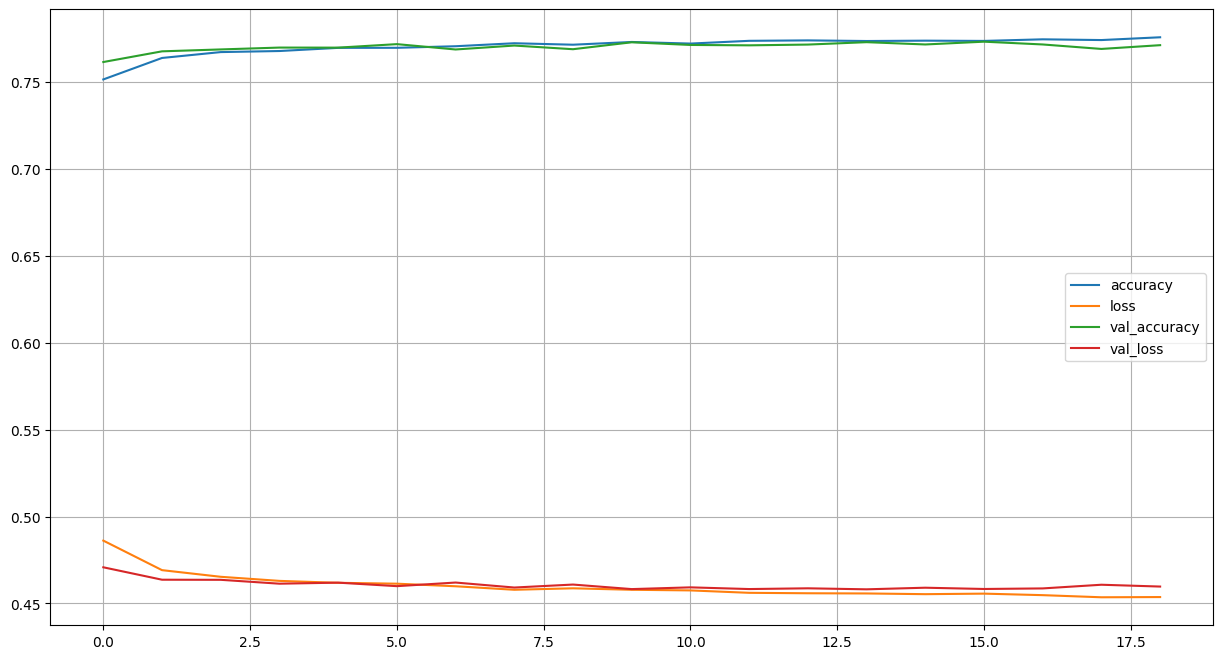

In [29]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.show()

In [33]:
# 1. On récupère les probabilités (ex: 0.8, 0.12, 0.99...)
y_prob = best_model.predict(X_test)

# 2. CORRECTION : On convertit en 0 ou 1 avec un seuil de 50%
# Si c'est supérieur à 0.5 -> C'est un 1 (Fumeur). Sinon -> 0.
y_classes = (y_prob > 0.5).astype("int32")

996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step


In [34]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

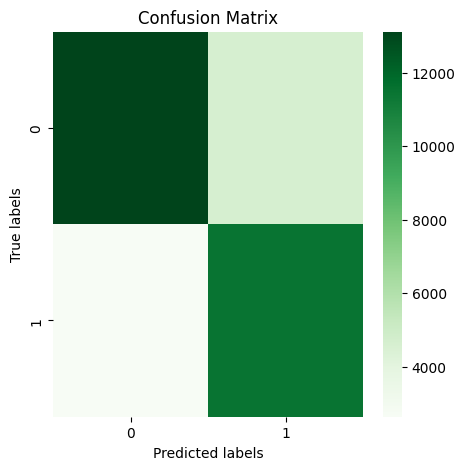

In [35]:
import seaborn as sb    
class_names=[0,1]
# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix,  cmap='Greens')  

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(5, 5)


plt.show()